Stone Soup 05 - Multi-Target
====================

In [1]:
# Some general imports and set up
import matplotlib
%matplotlib inline

from itertools import cycle
from datetime import timedelta
from datetime import datetime

import numpy as np

Simulate data
--------------
Like last time start we'll create a simple truth path, with position at 1 second interval. This will represent an object moving constantly in both $x$ and $y$.

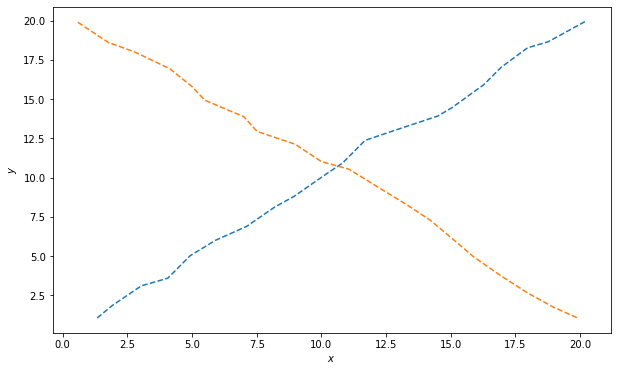

In [2]:
from stonesoup.types.groundtruth import GroundTruthPath, GroundTruthState

# Figure to plot truth (and future data)
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")

truths = set()

truth = GroundTruthPath()
start_time = datetime.now()
for n in range(1, 21):
    x = n
    y = n
    varxy = np.array([[0.05,0],[0,0.05]])
    xy = np.random.multivariate_normal(np.array([x,y]),varxy)
    truth.append(GroundTruthState(np.array([[xy[0]], [xy[1]]]), timestamp=start_time+timedelta(seconds=n)))
truths.add(truth)
    
truth = GroundTruthPath()
for n in range(1, 21):
    x = n
    y = 21-n
    varxy = np.array([[0.05,0],[0,0.05]])
    xy = np.random.multivariate_normal(np.array([x,y]),varxy)
    truth.append(GroundTruthState(np.array([[xy[0]], [xy[1]]]), timestamp=start_time+timedelta(seconds=n)))
truths.add(truth)

colors = matplotlib.rcParams['axes.prop_cycle'].by_key()['color']
for truth in truths:
    #Plot the result
    ax.plot([state.state_vector[0, 0] for state in truth], 
            [state.state_vector[1, 0] for state in truth], 
            linestyle="--")
    colors.pop(0) # Don't use colors for tracks later

Generate some measurements with uniform probability of detection.

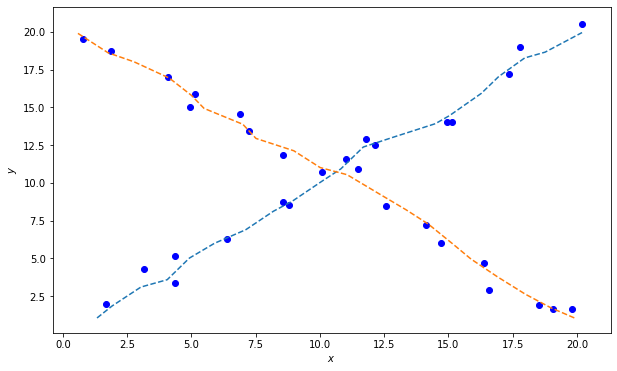

In [3]:
from scipy.stats import multivariate_normal

from stonesoup.types.detection import Detection

measurementss = [set() for _ in range(20)]
for truth in truths:
    for n, state in enumerate(truth):
        if np.random.rand() <= 0.85: # Probability of detection
            x, y = multivariate_normal.rvs(
                state.state_vector.ravel(), cov=np.diag([0.25, 0.25]))
            measurementss[n].add(Detection(
                np.array([[x], [y]]), timestamp=state.timestamp))
    
# Plot the result
ax.scatter([state.state_vector[0, 0] for measurements in measurementss for state in measurements], 
           [state.state_vector[1, 0] for measurements in measurementss for state in measurements], 
           color='b')
fig

And now we'll generate some clutter in the area at each timestep.

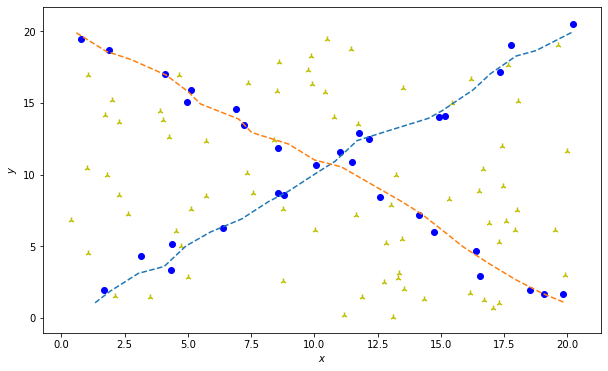

In [4]:
from scipy.stats import uniform

from stonesoup.types.detection import Clutter  # Same as a detections

clutter = []
for n in range(1, 21):
    clutter.append(set())
    for _ in range(np.random.randint(10)):
        x = uniform.rvs(0, 20)
        y = uniform.rvs(0, 20)
        clutter[-1].add(Clutter(
            np.array([[x], [y]]), timestamp=start_time+timedelta(seconds=n)))
# Plot the result
ax.scatter([state.state_vector[0, 0] for clutter_set in clutter for state in clutter_set], 
           [state.state_vector[1, 0] for clutter_set in clutter for state in clutter_set], 
           color='y', marker='2')
fig

Create Models and Kalman Filter
---------------------------------
Now we have our measurements and clutter, we'll create our models and Kalman filter.

In [5]:
from stonesoup.models.transition.linear import CombinedLinearGaussianTransitionModel, ConstantVelocity
transition_model = CombinedLinearGaussianTransitionModel((ConstantVelocity(0.1), ConstantVelocity(0.1)))

In [6]:
from stonesoup.predictor.kalman import KalmanPredictor
predictor = KalmanPredictor(transition_model)

In [7]:
from stonesoup.models.measurement.linear import LinearGaussian
measurement_model = LinearGaussian(
    4, # Number of state dimensions (position and velocity in 2D)
    (0,2), # Mapping measurement vector index to state index
    np.array([[0.25, 0],  # Covariance matrix for Gaussian PDF
              [0, 0.25]])
    )

In [8]:
from stonesoup.updater.kalman import KalmanUpdater
updater = KalmanUpdater(measurement_model)

For data association, we use the same hypothesier as before, but this time we use the Global Nearest Neighbour, which will choose the best combination of measurements to predicted states, such each measurement is associated to only one track.

In [9]:
from stonesoup.hypothesiser.distance import DistanceHypothesiser
from stonesoup.measures import Mahalanobis
hypothesiser = DistanceHypothesiser(predictor, updater, measure=Mahalanobis(), missed_distance=3)

In [10]:
from stonesoup.dataassociator.neighbour import GlobalNearestNeighbour
data_associator = GlobalNearestNeighbour(hypothesiser)

Running the Kalman Filter
--------------------------
Now we have the components, we can run our simulated data through the Kalman Filter.

To start, we'll need to create a prior estimaite of where we think our target will be.

In [11]:
from stonesoup.types.state import GaussianState
prior_one = GaussianState([[0], [1], [0], [1]], np.diag([0.25, 0.1, 0.25, 0.1]), timestamp=start_time)
prior_two = GaussianState([[0], [1], [21], [-1]], np.diag([0.25, 0.1, 0.25, 0.1]), timestamp=start_time)

With this, we'll now loop through our measurements, predicting and updating at each timestep.

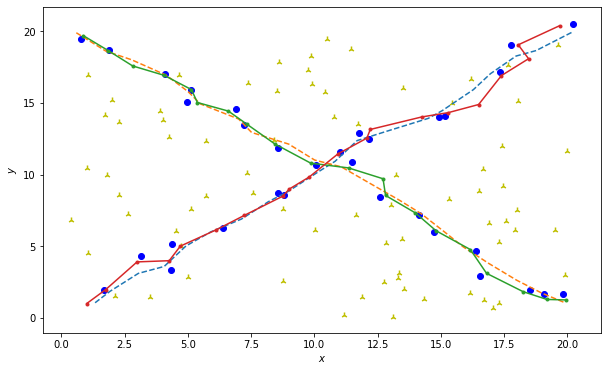

In [12]:
from stonesoup.types.track import Track

tracks = {Track([prior_one]), Track([prior_two])}
for n, (measurements, clutter_set) in enumerate(zip(measurementss, clutter), 1):
    detections = clutter_set.copy()
    detections.update(measurements) # Add measurements and clutter together
    
    hypotheses = data_associator.associate(tracks, detections, start_time+timedelta(seconds=n))
    for track in tracks:
        hypothesis = hypotheses[track]
        if hypothesis.measurement:
            post = updater.update(hypothesis)
            track.append(post)
        else: # When data associator says no detections are good enough, we'll keep the prediction
            track.append(hypothesis.prediction)

tracks_list = list(tracks)
for track, color in zip(tracks_list, cycle(colors)):
    # Plot the resulting track
    ax.plot([state.state_vector[0, 0] for state in track[1:]],  # Skip plotting the prior
            [state.state_vector[2, 0] for state in track[1:]],
            color=color, marker=".")
fig

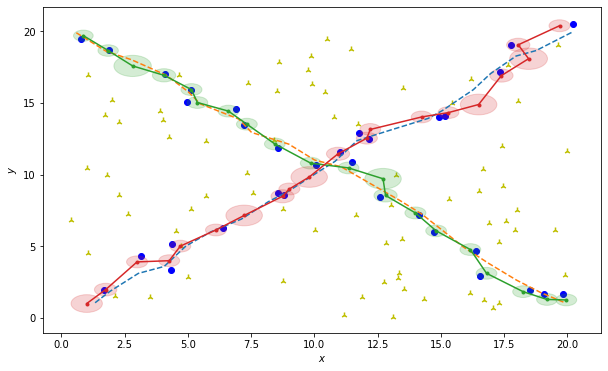

In [13]:
from matplotlib.patches import Ellipse
for track, color in zip(tracks_list, cycle(colors)):
    for state in track[1:]: # Skip the prior
        w, v = np.linalg.eig(measurement_model.matrix()@state.covar@measurement_model.matrix().T)
        max_ind = np.argmax(v[0, :])
        orient = np.arctan2(v[max_ind, 1], v[max_ind, 0])
        ellipse = Ellipse(xy=state.state_vector[(0,2), 0],
                          width=np.sqrt(w[0])*2, height=np.sqrt(w[1])*2,
                          angle=np.rad2deg(orient),
                          color=color, alpha=0.2)
        ax.add_artist(ellipse)
fig